# Academy Practicum 3

##  HARPS-GTO age estimation

----

### Motivation

In the previous parts of this practicum, we established a robust observational picture of the Galactic disk:
- we characterized the present-day radial metallicity structure using APOGEE × Gaia,
- we introduced stellar ages from asteroseismically calibrated APOGEE samples,
- and demonstrated that metallicity patterns evolve with time and radius.

However, stars do not necessarily remain at the Galactocentric radius where they were born.
Radial migration redistributes stars over billions of years, blurring the connection between present-day position and formation environment.

The central motivation of ACAP_003 is therefore:

**to reconstruct the Galactocentric birth radii of stars from their observed ages and metallicities, using empirical Galactic chemical evolution trends as a proxy for the interstellar medium (`ISM`).**

This step allows us to move from descriptive to reconstructive Galactic archaeology.

### Scientific idea

The core physical assumption behind this exercise is simple and transparent:
- At any given time, the ISM metallicity varied systematically with Galactocentric radius.
- Stars inherit the metallicity of the ISM at their birth location and time.
- If we know a star’s age and metallicity, and if we have an empirical model of ISM metallicity evolution, we can infer where that star most likely formed.

This practicum deliberately avoids full chemo-dynamical modeling and instead relies on:
- observationally calibrated trends,
- minimal parametric prescriptions,
- and explicit uncertainty propagation.

### Structure of the practicum

ACAP_003 is organized as a step-by-step reconstruction pipeline:
1.	Prepare stellar samples with ages, metallicities, and planetary information.
2.	Define an empirical, time-dependent ISM metallicity model.
3.	Invert this model to estimate stellar birth radii.
4.	Analyze how planet-hosting stars populate the reconstructed Galactic disk.
5.	Compare different stellar populations (single stars, planet hosts, high-/low-mass planets).

Each step corresponds to a small number of clearly labeled notebook cells.

### Data preprocessing pipeline

![Data pipeline for ACAP 003](../assets/ACAP_003_EN_Data_Pipeline.png)



----

## Cell 0. Notebook setup: paths and figure export

#### Purpose of this cell

This cell performs basic notebook initialization and defines a small utility that will be reused throughout the practical.
Its role is purely infrastructural: it does not perform any scientific computation or visualization yet.

Specifically, this cell:
1.	Finds the project root directory
The notebook may be executed from different subdirectories.
To make all paths robust and reproducible, we automatically walk up the directory tree until we find the folder named topics, which marks the project root.
2.	Defines the working directory for this practical
All outputs related to this practical (figures, animations, data products) are stored under
`topics/TOP_0001_exoplanet_birth_radius`.
3.	Creates a dedicated directory for exported figures
Figures generated in this notebook will be saved into a language-specific folder
(figures/en), which makes it easy to later export results to PDFs or reuse them in other products.
4.	Defines a helper function `save_fig()`
This function standardizes how figures are saved:
- consistent file format (`PNG`),
- consistent resolution (`DPI`),
- consistent layout (`bbox_inches="tight"`),
- and a single, predictable output location.

Using a helper function avoids repetitive boilerplate code and ensures that all figures
in the notebook are exported in a uniform way.

This setup allows us to focus on ideas and interpretation in later cells, without worrying about file paths or figure handling.

In [36]:
# =========================================================
# [ACAP_003|BOOTSTRAP] Notebook setup (imports, paths, theme, i18n)
# =========================================================

from __future__ import annotations

from pathlib import Path
from functools import partial
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch
from astropy import units as u

from lulab.io.paths import (
    get_topic_root,
    figures_dir,
    data_raw_dir,
    data_processed_dir,
    animations_dir,
)
from lulab.io.save_figure import save_fig
import lulab.io.theme as th

# -----------------------------
# Global notebook constants
# -----------------------------
TOPIC: str = "TOP_0001_exoplanet_birth_radius"
NOTEBOOK: str = "ACAP_003"
LANG: str = "en"   # "en" / "ru"

# --- physical limits (example; keep consistent with the practicum) ---
AGE_MIN_GYR = 0.1
AGE_MAX_GYR = 13.5
R_SUN = 8.0  # kpc

# -----------------------------
# Theme
# -----------------------------
th.set_theme("light")   # или th.apply_theme(th.THEME)

# -----------------------------
# Common paths (new style)
# -----------------------------
TOPIC_ROOT: Path = get_topic_root(TOPIC)
FIG_DIR: Path = figures_dir(TOPIC, lang=LANG, create=True)
DATA_RAW_DIR: Path = data_raw_dir(TOPIC, create=False)
DATA_PROCESSED_DIR: Path = data_processed_dir(TOPIC, create=True)
ANIM_DIR: Path = animations_dir(TOPIC, create=True)

# -----------------------------
# Save-figure helper bound to this topic/lang/notebook
# -----------------------------
def save_fig_nb(fig_id: str, *, fig):
    """
    Save figure with notebook-scoped ID to avoid collisions.

    Example:
        save_fig0("Figure_3", fig=fig)
    -> saved as:
        ACAP_001_Figure_3.png
    """
    full_id = f"{NOTEBOOK}_{fig_id}"
    return save_fig(full_id, fig=fig, topic=TOPIC, lang=LANG)

save_fig0 = save_fig_nb

# -----------------------------
# Backward-compatible aliases (so old cells don't break)
# -----------------------------
RAW = DATA_RAW_DIR
PROC = DATA_PROCESSED_DIR
FIG = FIG_DIR

# -----------------------------
# i18n bootstrap (optional now, but you'll need it later)
# -----------------------------
import lulab.i18n.plot_text as pt
importlib.reload(pt)

pt.set_lang(LANG)
if hasattr(pt, "set_notebook"):
    pt.set_notebook(NOTEBOOK)

pt.load_topic_i18n(TOPIC_ROOT, strict=True)
# pt.debug_i18n_state()

L = pt.L
T = pt.T

print("\n--- BOOTSTRAP ---")
print("LANG      :", LANG)
print("NOTEBOOK  :", NOTEBOOK)
print("FIG_DIR   :", FIG_DIR)
print("DATA_PROC :", DATA_PROCESSED_DIR)
print("THEME(mod):", th.THEME)


--- BOOTSTRAP ---
LANG      : en
NOTEBOOK  : ACAP_003
FIG_DIR   : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en
DATA_PROC : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed
THEME(mod): light


---

## Cell 1. Loading and cleaning the SWEET-Cat sample

### Purpose of this cell

This cell loads and prepares the SWEET-Cat catalog, which provides a curated sample of nearby FGK stars with well-characterized stellar parameters and planetary information.

SWEET-Cat plays a central role in this practicum because it defines the **planet-hosting stellar population** that will later be compared against Galactic chemical evolution trends and reconstructed birth radii.

### What this cell does

1. **Load the SWEET-Cat catalog**

   The catalog is read from the raw data directory as a CSV file.  
   This file contains stellar parameters (effective temperature, surface gravity, metallicity) and metadata for stars with detected planets.

2. **Select the high-quality SWEET-Cat subsample**

   We retain only stars with `SWFlag == 1`, which marks entries with:
   - homogeneous spectroscopic analysis,
   - reliable stellar parameters,
   - consistent parameter derivation across the catalog.

   This quality cut ensures that the SWEET-Cat sample is internally consistent and suitable for statistical analysis.

3. **Normalize column names**

   For convenience and consistency across different catalogs (`HARPS`, `APOGEE`, `Gaia`), we rename key stellar-parameter columns:
   - `Logg` → `logg`
   - `[Fe/H]` → `feh`

   This avoids conditional logic and special cases in later cells.

4. **Remove incomplete entries**

   Stars missing any of the core stellar parameters:
   - effective temperature (`Teff`),
   - surface gravity (`logg`),
   - metallicity (`feh`),

   are removed from the sample.

### Output

The result of this cell is a clean `sweet` DataFrame containing:
- a high-quality sample of planet-hosting stars,
- homogeneous stellar parameters,
- consistent column naming.

This DataFrame serves as the **planet-host reference population** throughout ACAP_003 and is later combined with age estimates and reconstructed Galactic birth radii.

In [ ]:
sweet = pd.read_csv(DATA_RAW_DIR / "sweetcat.csv")
sweet = sweet[sweet["SWFlag"] == 1].copy()

# normalize column names
sweet = sweet.rename(columns={"Logg":"logg", "Teff":"Teff", "[Fe/H]":"feh"})
sweet = sweet.dropna(subset=["Teff","logg","feh"])


----

## Cell 2. Loading and cleaning the HARPS comparison sample

### Purpose of this cell

This cell loads a reference stellar sample from the `HARPS-GTO` survey, which is used as a **comparison population** to the `SWEET-Cat` planet-hosting stars.

HARPS provides a large, homogeneous set of nearby FGK stars with well-measured atmospheric parameters, making it an ideal baseline for population-level comparisons.

### What this cell does

1. **Load the HARPS catalog from VizieR**

   The table `J/A+A/545/A32` is retrieved from VizieR without row limits, ensuring the full published sample is used.

2. **Standardize column names**

   The metallicity column `[Fe/H]` is renamed to `feh` for consistency with other datasets used in this practicum.

3. **Apply basic quality filtering**

   Stars are kept only if all core parameters are available:
   - effective temperature (`Teff`)
   - surface gravity (`logg`)
   - metallicity (`feh`)
   - stellar identifiers (`Star`, `SimbadName`)

### Output

The resulting `harps` DataFrame represents a clean, homogeneous **comparison sample of nearby field stars**, against which the properties of planet-hosting stars (`SWEET-Cat`) can be contrasted in later figures.

In [8]:
Vizier.ROW_LIMIT = -1
harps = Vizier.get_catalogs("J/A+A/545/A32")[0].to_pandas()

harps = harps.rename(columns={"[Fe/H]":"feh"})
harps = harps.dropna(subset=["Teff","logg","feh","Star","SimbadName"])

---

## Cell 3. Loading NEA planet catalog and defining planet-host classes

### Purpose of this cell

This cell loads planetary system data from the **NASA Exoplanet Archive (NEA)** and assigns a **planetary class** to each host star.
These classes are later used to separate stars hosting high-mass and low-mass planets, following the logic of the reference study.

### What this cell does

1. **Load the NEA planet catalog**

   The file `nea_ps_default_flag_1.csv` contains confirmed planetary systems with standardized parameters.

2. **Canonicalize host star names**

   Host star names appear in many inconsistent formats across catalogs.
   The helper function `canon_name()`:
   - normalizes case,
   - removes parentheses and whitespace,
   - replaces different dash characters,
   - strips non-alphanumeric symbols.

   This produces a robust `host_key` used for cross-matching with stellar catalogs (SWEET-Cat, HARPS).

3. **Extract planet masses**

   The code searches for the best available planet mass column:
   - `pl_bmassj`, `pl_massj` (Jupiter masses), or
   - `pl_masse` (Earth masses, converted to Jupiter masses).

   All masses are normalized to **Jupiter masses (`M_J`)**.

4. **Define planet-host classes**

   Each planet is classified as:
   - **HMPH** — High-Mass Planet Host
   - **LMPH** — Low-Mass Planet Host

   using a threshold:

In [9]:
import re

nea = pd.read_csv(RAW / "nea_ps_default_flag_1.csv")

def canon_name(x):
    if pd.isna(x): return ""
    s = str(x).strip().lower()
    s = s.replace("–","-").replace("—","-")
    s = re.sub(r"\(.*?\)", "", s)
    s = re.sub(r"\s+", "", s)
    s = re.sub(r"[^a-z0-9+\-]", "", s)
    return s

# host column
host_col = next(c for c in ["hostname","pl_hostname","sy_name","host_name","host"] if c in nea.columns)
nea["host_key"] = nea[host_col].map(canon_name)

# planet mass column (best-effort)
mp_col = next((c for c in ["pl_bmassj","pl_masse","pl_massj"] if c in nea.columns), None)
if mp_col is None:
    raise KeyError("NEA: не нашёл колонку массы планеты (pl_bmassj/pl_massj/pl_masse).")

# приводим к Mjup (если вдруг в Earth masses — грубо конвертим)
mp = pd.to_numeric(nea[mp_col], errors="coerce")
if "masse" in mp_col:
    mp_mj = mp / 317.8
else:
    mp_mj = mp

nea["mp_mj"] = mp_mj

# классы как в статье: high-mass vs low-mass (порог можно подстроить позже)
THRESH_MJ = 0.1  # пример: 0.1 Mj ~ 32 Mearth (порог уточним по статье при необходимости)
nea["planet_class"] = np.where(nea["mp_mj"] >= THRESH_MJ, "HMPH", "LMPH")

# по каждому хосту берём "максимальный" класс (если есть хотя бы одна HMPH -> HMPH)
host_max = (nea.dropna(subset=["host_key","planet_class"])
              .groupby("host_key")["planet_class"]
              .agg(lambda s: "HMPH" if (s=="HMPH").any() else "LMPH")
              .reset_index())

host_class = dict(zip(host_max["host_key"], host_max["planet_class"]))

---

## Cell 4. Cross-matching HARPS stars with planet-host classes

### Purpose of this cell

This cell links the **HARPS stellar sample** to the planet-host classifications derived from the NEA catalog.
As a result, each HARPS star is labeled as either:
- a **single star**, or
- a **planet host**, further divided into high-mass and low-mass planet hosts.

### What this cell does

1. **Canonicalize HARPS star names**

   HARPS stars can be identified by multiple name fields (`SimbadName`, `Star`).
   Both are normalized using the same `canon_name()` function as before, producing:
   - `name1`
   - `name2`

   This ensures robust matching across catalogs.

2. **Identify planet-host stars**

   A star is flagged as a planet host if either of its canonical names appears in the `host_class` dictionary constructed from NEA:
   ```python
   harps["is_host"] = name1 ∈ host_class OR name2 ∈ host_class

In [10]:
harps["name1"] = harps["SimbadName"].map(canon_name)
harps["name2"] = harps["Star"].map(canon_name)

harps["is_host"] = harps["name1"].isin(host_class) | harps["name2"].isin(host_class)
harps["class"] = "single"
harps.loc[harps["is_host"], "class"] = harps.loc[harps["is_host"], "name1"].map(host_class)
# fallback на name2
m = harps["class"].isna() & harps["is_host"]
harps.loc[m, "class"] = harps.loc[m, "name2"].map(host_class)

harps["class"] = harps["class"].fillna("single")
harps["class"].value_counts()

single    941
HMPH      132
LMPH       38
Name: class, dtype: int64

----

## Cell 5. Cache the MIST isochrone grid

### Purpose of this cell

This cell prepares and caches the **MIST stellar evolution model grid**, which is later used for age estimation.

Because downloading and constructing the MIST grid is computationally expensive, we do this **once** and store the result locally.

### What this cell does

1. **Check for a cached MIST grid**

   The cell looks for an existing file:

   `data/processed/mist_grid_cache.parquet`

2. **If the grid does not exist**
- Loads the MIST isochrone model via `isochrones.mist.MIST_Isochrone`
- Extracts the full model grid into a pandas DataFrame
- Saves it as a Parquet file for fast future access

3. **If the grid already exists**
- Skips model loading
- Reuses the cached grid

### Why this matters

- Ensures **reproducibility**: the same model grid is reused across runs
- Improves **performance**: avoids repeated downloads and parsing
- Decouples **stellar models** from observational data processing

This cached grid is later combined with observational parameters
($T_\mathrm{eff}$, $\log g$, [Fe/H]) to infer stellar ages in a consistent way.

In [11]:
grid_path = PROC / "mist_grid_cache.parquet"

if not grid_path.exists():
    from isochrones.mist import MIST_Isochrone
    iso = MIST_Isochrone()
    grid = iso.model_grid.df.copy()
    grid.to_parquet(grid_path, index=False)
    print("Built & saved:", grid_path, "shape:", grid.shape)
else:
    print("Exists:", grid_path)

Exists: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/mist_grid_cache.parquet


----

## Cell 6. Stellar age estimation using the MIST grid

### Purpose of this cell

This cell estimates stellar ages for the `SWEET-Cat` and `HARPS` samples by
matching observed stellar parameters to the MIST stellar evolution grid.

The goal is to obtain **homogeneous, model-based ages** that can later be
used to study:
- age–metallicity relations,
- planet host demographics,
- stellar birth radii.

### What is the MIST stellar evolution grid?

The **MIST (MESA Isochrones and Stellar Tracks)** grid is a large, physically consistent library of stellar evolution models computed with the `MESA` stellar evolution code.

For a wide range of stellar masses, metallicities, and evolutionary stages, the MIST grid provides predicted stellar parameters such as:
- effective temperature ($T_{\rm eff}$),
- surface gravity ($\log g$),
- luminosity,
- and stellar age.

Each point in the grid corresponds to a specific evolutionary state of a star with known physical age.

In this practicum, the MIST grid serves as a **theoretical bridge** between observable stellar parameters
($T_{\rm eff}$, $\log g$, [Fe/H]) and the otherwise unobservable quantity of interest — **stellar age**.

Rather than fitting individual stars in a fully Bayesian sense, we use the grid in a simplified but robust way:
- for each observed star, we search for the closest matching MIST model in parameter space,
- and assign the corresponding model age.

This approach has several advantages:
- it is fast and deterministic,
- it treats all samples consistently,
- and it is well suited for statistical population studies.

At the same time, it is important to emphasize that MIST-based ages are **model-dependent** and should not be interpreted as precise ages for individual stars. Their real strength lies in revealing **population-level trends**, which is exactly the focus of this practicum.


### Input data

1. **Cached MIST model grid**
   - Loaded from `mist_grid_cache.parquet`
   - Contains stellar parameters on evolutionary tracks
   - Age is provided as `log10(years)`

2. **Observed stellar parameters**
   - Effective temperature (`Teff`)
   - Surface gravity (`logg`)
   - Metallicity (`[Fe/H]` → `feh`)
   - From SWEET-Cat and HARPS samples

### What this cell does

1. **Prepare the MIST grid**
   - Remove incomplete grid points
   - Convert logarithmic ages to physical units (Gyr)

2. **Define a grid-based age fitting function**

   The function `fit_age_grid()`:
   - Selects MIST models close in metallicity to the observed star
   - Computes a simple χ² distance in (`Teff`, `logg`) space
   - Returns the age of the best-matching grid point

   This is a **deterministic nearest-grid-point estimate**, not a Bayesian fit.

3. **Compute ages for SWEET-Cat stars**
   - Loop over all SWEET-Cat entries
   - Estimate age for each star
   - Save results to:
     ```
     data/processed/sweetcat_ages_grid.csv
     ```

4. **Compute ages for HARPS stars**
   - Apply the same fitting procedure
   - Preserve host classification (`single`, `LMPH`, `HMPH`)
   - Save results to:
     ```
     data/processed/harps_ages_grid.csv
     ```

### Output products

| File name                | Content                                             | Purpose                              |
|--------------------------|-----------------------------------------------------|--------------------------------------|
| `sweetcat_ages_grid.csv` | SWEET-Cat stars with MIST-based ages                | Planet-host age analysis             |
| `harps_ages_grid.csv`    | HARPS stars with MIST-based ages and host class     | Population comparisons               |

### Important caveats

- These ages are **model-dependent** and should be interpreted statistically.
- Individual stellar ages are uncertain; trends over large samples are robust.
- The same fitting procedure is applied consistently to all samples.

This cell establishes the age backbone used throughout the rest of the practicum.

In [12]:
grid = pd.read_parquet(grid_path).dropna(subset=["age","feh","Teff","logg"]).copy()
# age is log10(years)
grid["age_gyr"] = (10 ** grid["age"]) / 1e9

def fit_age_grid(teff, logg, feh, ete=60.0, elg=0.10, efe=0.04):
    sub = grid[(grid["feh"] >= feh - 3*efe) & (grid["feh"] <= feh + 3*efe)]
    if len(sub) == 0:
        sub = grid[(grid["feh"] >= feh - 0.5) & (grid["feh"] <= feh + 0.5)]
        if len(sub) == 0:
            return np.nan
    chi2 = ((sub["Teff"]-teff)/ete)**2 + ((sub["logg"]-logg)/elg)**2
    return float(sub.loc[chi2.idxmin(), "age_gyr"])

# SWEET ages
sweet["age_gyr"] = [fit_age_grid(t,g,f) for t,g,f in tqdm(zip(sweet.Teff, sweet.logg, sweet.feh),
                                                          total=len(sweet), desc="SWEET ages")]
sweet_ages = sweet[["Teff","logg","feh","age_gyr"]].copy()
sweet_ages.to_csv(PROC / "sweetcat_ages_grid.csv", index=False)

# HARPS ages
harps["age_gyr"] = [fit_age_grid(t,g,f) for t,g,f in tqdm(zip(harps.Teff, harps.logg, harps.feh),
                                                          total=len(harps), desc="HARPS ages")]
harps_ages = harps[["Star","SimbadName","Teff","logg","feh","class","is_host","age_gyr"]].copy()
harps_ages.to_csv(PROC / "harps_ages_grid.csv", index=False)

print("Saved ages to:", PROC)

HARPS ages: 100%|██████████| 1111/1111 [00:07<00:00, 143.56it/s]

Saved ages to: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed


### Cell 7 — Reconstruct stellar birth radii ($r_{\rm birth}$) for the HARPS sample (toy GCE model)

This cell implements a simplified **Galactic chemical evolution (GCE)** prescription to translate *observed* stellar metallicities and ages into an estimate of each star’s **Galactocentric birth radius**.

#### Idea (what we assume)
We approximate the interstellar medium (ISM) metallicity as a function of radius and time by combining two ingredients:

1) **Time-dependent radial metallicity gradient**  
`grad_dfeh_dr(age_gyr)` returns a (negative) slope $d{\rm [Fe/H]}/dR$ that evolves with lookback time:  
- present-day disk: $\sim -0.07\ \mathrm{dex\,kpc^{-1}}$  
- early disk: $\sim -0.15\ \mathrm{dex\,kpc^{-1}}$  

2) **Time-dependent ISM metallicity at the solar radius**  
`feh_ism_rsun(age_gyr)` models enrichment at $R=R_\odot$ from an early low metallicity ($\sim -0.65$ dex) to today ($\sim 0$ dex), using a smooth logarithmic growth law.

Together, these define a toy ISM field:
$$ {\rm [Fe/H]}_{\rm ISM}(R,t)\approx {\rm [Fe/H]}_\odot(t) + \left(\frac{d{\rm [Fe/H]}}{dR}\right)(t)\,(R-R_\odot)$$

#### What we compute
For each HARPS star with a valid age, we solve this relation for the radius $R$ that would produce the star’s observed metallicity at its formation time:
$$ r_{\rm birth} \;=\; R_\odot + \frac{{\rm [Fe/H]}_\star - {\rm [Fe/H]}_\odot(t_\star)}{\left(d{\rm [Fe/H]}/dR\right)(t_\star)}$$

#### Inputs
- `harps_ages` (from previous cells): HARPS stars with
  - `age_gyr` (MIST grid-derived age),
  - `feh` (metallicity),
  - `class` (single / LMPH / HMPH labels).

#### Processing steps
- Apply age quality cuts (`0.1 ≤ age_gyr ≤ 13.5` and finite ages).
- Compute:
  - the ISM gradient at the star’s age,
  - the ISM metallicity at $R_\odot$ at the star’s age,
  - the corresponding `rbirth_kpc`.
- Clip results to a disk-like range (0.5–20 kpc) for presentation stability.

#### Outputs
- Saved file: `data/processed/harps_rbirth_gce.csv`
- Contents: HARPS table with ages + the reconstructed `rbirth_kpc`.
- The final printout shows the population split by `class`, allowing us to compare inferred birth radii across host/non-host (and planet-mass classes).

#### Why this matters
This is the *bridge* between stellar properties (age, [Fe/H]) and a Galactic context: it produces a first-order estimate of where in the disk each star likely formed, enabling later plots and comparisons that mirror the structure of the reference paper.

In [19]:
def grad_dfeh_dr(age_gyr):
    age = np.asarray(age_gyr, float)
    return -0.07 + (-0.15 + 0.07) * (age / 13.5)

def feh_ism_rsun(age_gyr):
    age = np.asarray(age_gyr, float)
    feh_now, feh_early, tau = 0.0, -0.65, 2.5
    x = np.log1p(age/tau) / np.log1p(13.5/tau)
    return feh_now + (feh_early - feh_now) * x

dfh = harps_ages.copy()
dfh = dfh[(dfh["age_gyr"]>=0.1) & (dfh["age_gyr"]<=13.5) & np.isfinite(dfh["age_gyr"])].copy()

grad = grad_dfeh_dr(dfh["age_gyr"].values)
feh0 = feh_ism_rsun(dfh["age_gyr"].values)

dfh["rbirth_kpc"] = (R_SUN + (dfh["feh"].values - feh0)/grad).clip(0.5, 20.0)

dfh.to_csv(PROC / "harps_rbirth_gce.csv", index=False)
print("Saved:", PROC / "harps_rbirth_gce.csv", "Rows:", len(dfh))
print(dfh["class"].value_counts())

Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/harps_rbirth_gce.csv Rows: 466
single    385
HMPH       66
LMPH       15
Name: class, dtype: int64


### Cell 8 — SWEET-Cat stellar sample: normalization and planet-host classification

This cell prepares the **SWEET-Cat** stellar catalog for joint analysis with HARPS and NEA-based planet information.

#### What this cell does

1. **Load and filter SWEET-Cat**
- Reads the raw `sweetcat.csv` table.
- Keeps only stars with `SWFlag == 1`, i.e. entries flagged as reliable in SWEET-Cat.
- Drops stars with missing fundamental parameters (`Teff`, `logg`, `[Fe/H]`, `Name`).

2. **Normalize column names**
For consistency with the rest of the notebook:
- `Logg → logg`
- `Teff → Teff`
- `[Fe/H] → feh`

This ensures that SWEET, HARPS, and MIST-grid operations can reuse the same code paths.

3. **Canonicalize stellar names**
- The `Name` column is converted into a normalized `host_key` using the same `canon_name()` function as before.
- This allows robust matching against the NEA host list, despite formatting differences.

4. **Assign planet-host classes**
Using the previously constructed `host_class` dictionary (from NEA):
- Stars not found in NEA are labeled as `"single"`.
- Planet hosts are classified as:
  - `HMPH` — hosts of at least one high-mass planet,
  - `LMPH` — hosts of only low-mass planets.

If a star hosts multiple planets, the **maximum-mass class dominates**, matching the logic used earlier for HARPS.

5. **Quick diagnostic**
A `value_counts()` printout shows how many SWEET stars fall into each class, providing an immediate sanity check.

#### Why this cell matters

SWEET-Cat occupies a key role in the practicum:
- It provides a **high-quality, homogeneous reference sample** of planet-hosting stars.
- It anchors the **top row of the final comparison figures**, mirroring the structure used in the reference paper.
- Keeping SWEET as a distinct dataset preserves transparency and avoids mixing assumptions across samples.

At this stage, SWEET stars are fully normalized, classified, and ready for age fitting and comparative visualization.

In [22]:
# SWEET columns already normalized earlier? If not:
sweet = pd.read_csv(RAW / "sweetcat.csv")
sweet = sweet[sweet["SWFlag"] == 1].copy()
sweet = sweet.rename(columns={"Logg":"logg", "Teff":"Teff", "[Fe/H]":"feh"})
sweet = sweet.dropna(subset=["Teff","logg","feh","Name"]).copy()

sweet["host_key"] = sweet["Name"].map(canon_name)

# class from NEA host_class dict (HMPH/LMPH)
sweet["is_host"] = sweet["host_key"].isin(host_class)
sweet["class"] = "single"
sweet.loc[sweet["is_host"], "class"] = sweet.loc[sweet["is_host"], "host_key"].map(host_class)
sweet["class"] = sweet["class"].fillna("single")

print(sweet["class"].value_counts())

HMPH      805
LMPH      253
single    125
Name: class, dtype: int64


---

### Cell 9 — SWEET-Cat ages from the MIST grid (fast grid fit)

This cell estimates **stellar ages for SWEET-Cat stars** by matching each star to a precomputed **MIST isochrone grid**.

#### Inputs
- `data/processed/mist_grid_cache.parquet` — cached MIST model grid (built earlier)
- `sweet` DataFrame — SWEET-Cat stars with normalized columns:
  - `Teff`, `logg`, `feh`, plus `Name`, `class`, `is_host`

#### What this cell does

1. **Load the MIST grid**
- Reads the cached grid from `mist_grid_cache.parquet`
- Keeps only rows with valid (`age`, `feh`, `Teff`, `logg`)
- Converts `age` from `log10(years)` to **Gyr**:
  - `age_gyr = 10**age / 1e9`

2. **Define a lightweight grid-fitting function**
`fit_age_grid(teff, logg, feh)` does a brute-force nearest-model match:
- First filters the grid to a narrow metallicity slice around the star:
  - `feh ± 3σ` where `σ = efe = 0.04 dex`
- If that slice is empty, falls back to a wider window:
  - `feh ± 0.5 dex`
- Computes a simple χ² distance using assumed measurement errors:
  - `ete = 60 K`, `elg = 0.10 dex`, `efe = 0.04 dex`
- Returns the model point with minimum χ² → adopted `age_gyr`

This is not a full Bayesian isochrone fit — it is a **fast, deterministic grid match** suitable for building a practicum-scale pipeline.

3. **Compute ages for all SWEET stars**
- Runs `fit_age_grid()` for each SWEET star using `tqdm` progress reporting
- Stores the result in a new column: `sweet["age_gyr"]`

4. **Apply physical age cuts**
To avoid model edge effects and pathological matches:
- keep only `0.1 ≤ age_gyr ≤ 13.5`
- require finite ages

5. **Save the processed age table**
Writes the final SWEET-Cat sample with ages to:
- `data/processed/sweetcat_ages_grid.csv`

Saved columns:
- `Name, Teff, logg, feh, class, is_host, age_gyr`

6. **Quick diagnostics**
Prints:
- number of saved rows
- class breakdown (`single`, `LMPH`, `HMPH`)

#### Outputs
- `sweetcat_ages_grid.csv` — SWEET-Cat stars with MIST-grid ages (used downstream in multi-panel comparisons)

#### Why this cell matters
SWEET-Cat is a key “anchor sample” in the final figure layout (top row).  
By adding **ages on the same footing** (same grid + same fitting assumptions), we can:
- compare SWEET vs HARPS consistently,
- separate host classes (HMPH/LMPH/single),
- and later connect age + [Fe/H] to reconstructed birth radii.

In [23]:
grid_path = PROC / "mist_grid_cache.parquet"
grid = pd.read_parquet(grid_path).dropna(subset=["age","feh","Teff","logg"]).copy()
grid["age_gyr"] = (10 ** grid["age"]) / 1e9  # age is log10(years)

def fit_age_grid(teff, logg, feh, ete=60.0, elg=0.10, efe=0.04):
    sub = grid[(grid["feh"] >= feh - 3*efe) & (grid["feh"] <= feh + 3*efe)]
    if len(sub) == 0:
        sub = grid[(grid["feh"] >= feh - 0.5) & (grid["feh"] <= feh + 0.5)]
        if len(sub) == 0:
            return np.nan
    chi2 = ((sub["Teff"]-teff)/ete)**2 + ((sub["logg"]-logg)/elg)**2
    return float(sub.loc[chi2.idxmin(), "age_gyr"])

sweet["age_gyr"] = [
    fit_age_grid(t,g,f)
    for t,g,f in tqdm(zip(sweet.Teff, sweet.logg, sweet.feh),
                      total=len(sweet), desc="SWEET ages (grid)")
]

sweet = sweet[(sweet["age_gyr"]>=0.1) & (sweet["age_gyr"]<=13.5) & np.isfinite(sweet["age_gyr"])].copy()

out_ages = PROC / "sweetcat_ages_grid.csv"
sweet[["Name","Teff","logg","feh","class","is_host","age_gyr"]].to_csv(out_ages, index=False)
print("Saved:", out_ages, "Rows:", len(sweet))
print(sweet["class"].value_counts())

SWEET ages (grid): 100%|██████████| 1183/1183 [00:08<00:00, 133.70it/s]

Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_ages_grid.csv Rows: 605
HMPH      436
LMPH      101
single     68
Name: class, dtype: int64


---

### Cell 10 — Reconstruction of stellar birth radii (SWEET-Cat, toy GCE model)

This cell reconstructs **Galactocentric birth radii** for SWEET-Cat stars using a simplified (toy) Galactic Chemical Evolution (GCE) prescription.  
The main idea: given a star’s **age** and **metallicity [Fe/H]**, estimate at what Galactic radius the ISM metallicity would match the observed value.

#### Inputs

- DataFrame `sweet` must already contain:
  - `age_gyr` — stellar ages (from the MIST grid fit)
  - `feh` — metallicity [Fe/H]
  - (optional metadata) `Name`, `Teff`, `logg`, `class`, `is_host`
- Constant: `R_SUN = 8.0` kpc (Solar Galactocentric radius)


#### Step 1 — Time-dependent ISM metallicity gradient

We adopt a toy time evolution for the radial ISM gradient  
`grad_dfeh_dr(age_gyr) = d[Fe/H]/dR`.

Assumption: the gradient is
- **steeper** at early epochs (≈ −0.15 dex/kpc),
- **flatter** today (≈ −0.07 dex/kpc).

This reflects the qualitative expectation that the disk gradient flattens over time.


#### Step 2 — ISM metallicity at the Solar radius vs time

We also define a toy enrichment law for the ISM at the Solar circle:  
`feh_ism_rsun(age_gyr) = [Fe/H]_ISM(R=R_SUN, age)`.

Assumption: the early disk is metal-poor (≈ −0.65 dex), and enrichment approaches ~0 dex at the present day.


#### Step 3 — Invert the gradient to get birth radius

For each star we solve:

`r_birth = R_SUN + ([Fe/H]_star − [Fe/H]_ISM(R_SUN, age)) / (d[Fe/H]/dR(age))`

Implementation details:
- compute `grad = grad_dfeh_dr(sweet["age_gyr"])`
- compute `feh0 = feh_ism_rsun(sweet["age_gyr"])`
- assign `sweet["rbirth_kpc"]`
- clip to a presentation/physics-friendly range: `0.5 … 20.0` kpc


#### Outputs

CSV written to:

`data/processed/sweetcat_rbirth_gce.csv`

with columns:

`Name, Teff, logg, feh, class, is_host, age_gyr, rbirth_kpc`


#### Interpretation

This is the key inference step that links stellar properties to Galactic context:
- Stars with higher [Fe/H] at a given age tend to map to **smaller** `r_birth` (inner disk).
- Stars with lower [Fe/H] at a given age tend to map to **larger** `r_birth` (outer disk).
- Comparing `r_birth` distributions between planet-host classes vs single stars provides a proxy test for formation environment + migration effects.

The model is intentionally simple, but the workflow matches the standard logic used in Galactic archaeology: infer birth conditions from chemo-age observables under an explicit ISM enrichment prescription.

In [24]:
def grad_dfeh_dr(age_gyr):
    age = np.asarray(age_gyr, float)
    return -0.07 + (-0.15 + 0.07) * (age / 13.5)

def feh_ism_rsun(age_gyr):
    age = np.asarray(age_gyr, float)
    feh_now, feh_early, tau = 0.0, -0.65, 2.5
    x = np.log1p(age/tau) / np.log1p(13.5/tau)
    return feh_now + (feh_early - feh_now) * x

grad = grad_dfeh_dr(sweet["age_gyr"].values)
feh0 = feh_ism_rsun(sweet["age_gyr"].values)

sweet["rbirth_kpc"] = (R_SUN + (sweet["feh"].values - feh0)/grad).clip(0.5, 20.0)

out_r = PROC / "sweetcat_rbirth_gce.csv"
sweet[["Name","Teff","logg","feh","class","is_host","age_gyr","rbirth_kpc"]].to_csv(out_r, index=False)
print("Saved:", out_r, "Rows:", len(sweet))

Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_rbirth_gce.csv Rows: 605


----

### Cell 11 — Final multi-panel comparison: planet-host frequency vs age and birth radius (SWEET-Cat vs HARPS-GTO)

This cell produces the **main summary figure of Practicum 3**, designed to mirror the structure of the reference paper:  
a 2×2 “block” layout (counts + relative frequencies) shown for **two stellar samples** (SWEET-Cat and HARPS-GTO) and for **two key variables** (age and reconstructed birth radius).


#### Goal of this figure

We want to test whether the incidence of different planet-host classes varies systematically with:

1) **stellar age** (a proxy for formation epoch)  
2) **Galactocentric birth radius** `r_birth` (a proxy for formation environment in the disk)

and to compare how these trends look in:
- **SWEET-Cat** (planet-host focused sample)  
- **HARPS-GTO** (more survey-like control sample)


#### Inputs (data products)

The cell loads the final, reproducible CSV products built earlier:

- `data/processed/sweetcat_rbirth_gce.csv`  
  Contains SWEET-Cat stars with `age_gyr`, `[Fe/H]`, reconstructed `rbirth_kpc`, plus class labels.

- `data/processed/harps_rbirth_gce.csv`  
  Same, but for HARPS-GTO.

After loading, we filter to finite values for:
- `age_gyr`
- `rbirth_kpc`


#### Planet-host classes used

Each star is assigned one of three classes (derived from NEA cross-matching):

- `single` — no detected planets  
- `LMPH` — Low-Mass Planet Host (at least one planet below the mass threshold)  
- `HMPH` — High-Mass Planet Host (at least one planet above the threshold)

Plot styling is set via two dictionaries:
- `COL` — colors per class  
- `MRK` — markers per class  


#### What is computed

For each dataset (`sweet` and `harps`) and for each x-variable (`age_gyr` and `rbirth_kpc`) we compute:

1) **Counts per bin**
- `Ns`: number of `single` stars
- `Nh`: number of `HMPH` stars
- `Nl`: number of `LMPH` stars
- `Nt = Ns + Nh + Nl`: total

2) **Relative frequencies**
- `F_HMPH = Nh / Nt`
- `F_LMPH = Nl / Nt`

3) **Uncertainty on frequencies**
We use a simple binomial estimate:

`σ(F) ≈ sqrt( F (1 − F) / N )`

This is implemented in `frac_and_err()` and shown as error bars.


#### Binning configuration (paper-like)

**Age**
- bin width: 2.5 Gyr (`age_bins = 0 … 15 step 2.5`)
- the first bin (0–2.5 Gyr) is **excluded** from plotting (`mask_age`) to match the paper-style presentation

**Birth radius**
- bins: 0 … 16 kpc with step 2 kpc (`r_bins`)
- axes are shown on the same range for easy comparison

**Note on r_birth clipping**
`rbirth_kpc` is clipped to `0 … 20` kpc for consistency and to avoid pathological values; the visible plot range is `0 … 16` kpc.


#### What is shown on the figure

The figure is a **2 rows × 4 columns** grid:

**Columns 1–2 (Age):**
- left: counts vs age (Ns, Nh, Nl)
- right: relative frequencies vs age (HMPH/Nt and LMPH/Nt)

**Columns 3–4 (Birth radius):**
- left: counts vs r_birth
- right: relative frequencies vs r_birth

**Rows:**
- top row: SWEET-Cat
- bottom row: HARPS-GTO

Frequency axes are “zoomed” in the HARPS row (`freq_ylim`) to highlight small fractions.


#### Output

The figure is saved via the project helper:

- `figures/<lang>/Figure_8.png` (or with notebook-specific prefix if enabled in your save helper)

This figure is intended to be the **final diagnostic summary** of the practicum:
it connects **survey-based disk enrichment trends → reconstructed birth radii → planet-host demographics** in a single publication-style visualization.

Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ACAP_003_Figure_1.png


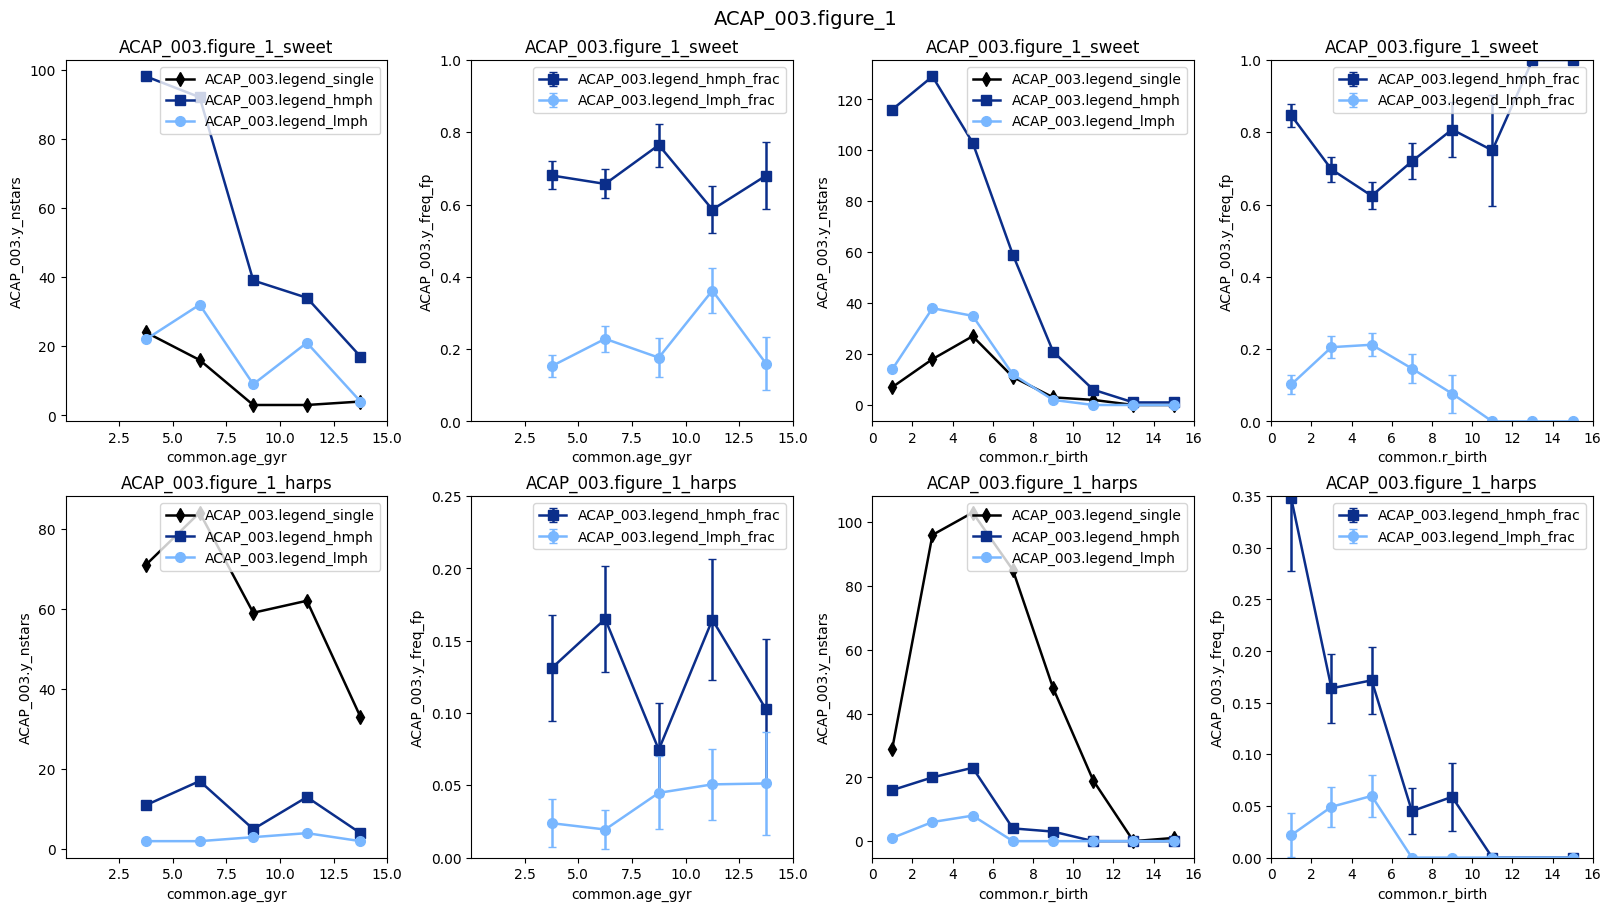

In [33]:
# =========================================================
# [ACAP_003|FIG_1] Figure 1 (i18n titles + i18n legend)
# Inputs:
#   - data/processed/sweetcat_rbirth_gce.csv
#   - data/processed/harps_rbirth_gce.csv
# Output:
#   - figure saved via save_fig0(...)
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sweet = pd.read_csv(DATA_PROCESSED_DIR / "sweetcat_rbirth_gce.csv")
harps = pd.read_csv(DATA_PROCESSED_DIR / "harps_rbirth_gce.csv")

sweet = sweet[np.isfinite(sweet["age_gyr"]) & np.isfinite(sweet["rbirth_kpc"])].copy()
harps = harps[np.isfinite(harps["age_gyr"]) & np.isfinite(harps["rbirth_kpc"])].copy()

# --- paper-like style (leave as-is for now)
COL = {"single": "k", "HMPH": "#0B2E8A", "LMPH": "#79B7FF"}
MRK = {"single": "d", "HMPH": "s", "LMPH": "o"}
LW, MS, CAP = 1.8, 7, 3

# i18n labels
LBL_SINGLE = L("ACAP_003.legend_single")
LBL_HMPH   = L("ACAP_003.legend_hmph")
LBL_LMPH   = L("ACAP_003.legend_lmph")
LBL_H_FRAC = L("ACAP_003.legend_hmph_frac")
LBL_L_FRAC = L("ACAP_003.legend_lmph_frac")

Y_NSTARS = L("ACAP_003.y_nstars")
Y_FP     = L("ACAP_003.y_freq_fp")

X_AGE = L("common.age_gyr")
X_RB  = L("common.r_birth")

TITLE_FIG = T("ACAP_003.figure_1")
TITLE_SWE = T("ACAP_003.figure_1_sweet")
TITLE_HAR = T("ACAP_003.figure_1_harps")

def counts_in_bins(df, xcol, bins, cls):
    x = df.loc[df["class"] == cls, xcol].dropna().to_numpy()
    return np.histogram(x, bins=bins)[0]

def frac_and_err(k, n):
    k = np.asarray(k, float)
    n = np.asarray(n, float)
    p = np.full_like(k, np.nan)
    err = np.full_like(k, np.nan)
    m = n > 0
    p[m] = k[m] / n[m]
    err[m] = np.sqrt(np.clip(p[m] * (1 - p[m]) / n[m], 0, None))
    return p, err

def plot_block(
    ax_counts, ax_freq, df, xcol, bins, xcent,
    xlabel, title, freq_ylim=(0, 1),
    mask_bins=None, xlim=None, xticks=None
):
    Ns = counts_in_bins(df, xcol, bins, "single")
    Nh = counts_in_bins(df, xcol, bins, "HMPH")
    Nl = counts_in_bins(df, xcol, bins, "LMPH")
    Nt = Ns + Nh + Nl

    if mask_bins is not None:
        Ns, Nh, Nl, Nt = Ns[mask_bins], Nh[mask_bins], Nl[mask_bins], Nt[mask_bins]
        xcent = xcent[mask_bins]

    # --- counts
    ax_counts.plot(xcent, Ns, marker=MRK["single"], ms=MS, lw=LW, color=COL["single"], label=LBL_SINGLE)
    ax_counts.plot(xcent, Nh, marker=MRK["HMPH"],   ms=MS, lw=LW, color=COL["HMPH"],   label=LBL_HMPH)
    ax_counts.plot(xcent, Nl, marker=MRK["LMPH"],   ms=MS, lw=LW, color=COL["LMPH"],   label=LBL_LMPH)

    ax_counts.set_title(title)
    ax_counts.set_xlabel(xlabel)
    ax_counts.set_ylabel(Y_NSTARS)
    ax_counts.legend(loc="upper right", frameon=True)

    # --- frequency
    ph, eh = frac_and_err(Nh, Nt)
    pl, el = frac_and_err(Nl, Nt)

    m = (Nt > 0) & np.isfinite(ph) & np.isfinite(eh)
    ax_freq.errorbar(
        xcent[m], ph[m], yerr=eh[m],
        marker=MRK["HMPH"], ms=MS, lw=LW, capsize=CAP,
        color=COL["HMPH"], label=LBL_H_FRAC
    )

    m = (Nt > 0) & np.isfinite(pl) & np.isfinite(el)
    ax_freq.errorbar(
        xcent[m], pl[m], yerr=el[m],
        marker=MRK["LMPH"], ms=MS, lw=LW, capsize=CAP,
        color=COL["LMPH"], label=LBL_L_FRAC
    )

    ax_freq.set_title(title)
    ax_freq.set_xlabel(xlabel)
    ax_freq.set_ylabel(Y_FP)
    ax_freq.set_ylim(*freq_ylim)
    ax_freq.legend(loc="upper right", frameon=True)

    if xlim is not None:
        ax_counts.set_xlim(*xlim)
        ax_freq.set_xlim(*xlim)
    if xticks is not None:
        ax_counts.set_xticks(xticks)
        ax_freq.set_xticks(xticks)

# =========================================================
# Re-clip rbirth to start at 0 (paper-like pile-up)
# =========================================================
sweet["rbirth_kpc"] = np.clip(sweet["rbirth_kpc"].to_numpy(float), 0.0, 20.0)
harps["rbirth_kpc"] = np.clip(harps["rbirth_kpc"].to_numpy(float), 0.0, 20.0)

# =========================================================
# Binning / ticks like paper
# =========================================================
age_bins = np.arange(0.0, 15.0 + 0.001, 2.5)
age_cent = 0.5 * (age_bins[:-1] + age_bins[1:])
mask_age = age_cent >= 2.5
age_ticks = age_bins[1:]
age_xlim = (0.0, 15.0)

r_bins = np.arange(0.0, 16.0 + 0.001, 2.0)
r_cent = 0.5 * (r_bins[:-1] + r_bins[1:])
r_ticks = np.arange(0, 17, 2)
r_xlim = (0.0, 16.0)

# =========================================================
# Combined Figure_1: 2 rows x 4 cols
# =========================================================
fig = plt.figure(figsize=(16, 9), constrained_layout=True)
gs = fig.add_gridspec(2, 4)

ax = {}
ax["s_age_cnt"] = fig.add_subplot(gs[0, 0]); ax["s_age_frq"] = fig.add_subplot(gs[0, 1])
ax["h_age_cnt"] = fig.add_subplot(gs[1, 0]); ax["h_age_frq"] = fig.add_subplot(gs[1, 1])
ax["s_r_cnt"]   = fig.add_subplot(gs[0, 2]); ax["s_r_frq"]   = fig.add_subplot(gs[0, 3])
ax["h_r_cnt"]   = fig.add_subplot(gs[1, 2]); ax["h_r_frq"]   = fig.add_subplot(gs[1, 3])

fig.suptitle(TITLE_FIG, fontsize=14)

# SWEET
plot_block(
    ax["s_age_cnt"], ax["s_age_frq"], sweet, "age_gyr",
    age_bins, age_cent, X_AGE, TITLE_SWE,
    freq_ylim=(0, 1), mask_bins=mask_age, xlim=age_xlim, xticks=age_ticks
)

plot_block(
    ax["s_r_cnt"], ax["s_r_frq"], sweet, "rbirth_kpc",
    r_bins, r_cent, X_RB, TITLE_SWE,
    freq_ylim=(0, 1), xlim=r_xlim, xticks=r_ticks
)

# HARPS
plot_block(
    ax["h_age_cnt"], ax["h_age_frq"], harps, "age_gyr",
    age_bins, age_cent, X_AGE, TITLE_HAR,
    freq_ylim=(0, 0.25), mask_bins=mask_age, xlim=age_xlim, xticks=age_ticks
)

plot_block(
    ax["h_r_cnt"], ax["h_r_frq"], harps, "rbirth_kpc",
    r_bins, r_cent, X_RB, TITLE_HAR,
    freq_ylim=(0, 0.35), xlim=r_xlim, xticks=r_ticks
)

save_fig0("Figure_1", fig=fig)
plt.show()

*Figure 1. Number of stars and exoplanet occurrence rate as a function of stellar age and reconstructed Galactocentric birth radius for the SWEET-Cat sample.*

### Overview of Figure 1

This figure summarizes how the occurrence of planetary systems depends on **stellar age** and **Galactocentric birth radius**, based on reconstructed birth locations and stellar ages.

The top row shows results for the **SWEET-Cat** sample, while the bottom row shows the independent **HARPS-GTO** sample. Each sample is presented in two complementary projections:

- **Left panels (Age dependence):**
  The number of stars and the relative frequency of planet hosts are shown as a function of stellar age.
  High-mass planet hosts (HMPHs) dominate at younger and intermediate ages, while their fraction decreases for older stars.

- **Right panels (Birth-radius dependence):**
  The same quantities are shown as a function of reconstructed Galactocentric birth radius.
  Planet hosts, especially HMPHs, are preferentially associated with stars born in the **inner Galactic disk**, while their frequency drops sharply toward larger birth radii.

Across both datasets, the qualitative trends are consistent:
- HMPHs are more common among stars formed at smaller Galactocentric radii and at younger ages.
- Low-mass planet hosts (LMPHs) show a weaker but still structured dependence.
- The agreement between SWEET-Cat and HARPS-GTO indicates that the trends are not driven by a single survey or selection effect.

Overall, the figure provides strong observational evidence that **planet occurrence is linked to the Galactic chemical evolution history and the birth environment of stars**.

----

### Cell 12. Planet-host frequency as a function of stellar birth radius

#### Purpose of this cell

This cell produces the **key diagnostic figure of Practicum 3**, showing how the frequency of planet-hosting stars depends on the **Galactocentric birth radius** of their host stars, and how this dependence varies with stellar age.

The figure closely follows the structure and logic of the reference study and represents the final synthesis of all previous steps in the pipeline.

#### Input data

The cell uses two processed datasets generated earlier in the notebook:

- `sweetcat_rbirth_gce.csv`  
  SWEET-Cat stars with:
  - stellar parameters,
  - MIST-grid ages,
  - reconstructed birth radii,
  - planet-host classification (single / LMPH / HMPH).

- `harps_rbirth_gce.csv`  
  HARPS-GTO stars with the same derived quantities.

Only stars with finite ages and finite reconstructed birth radii are retained.


#### What is computed

For each dataset (SWEET-Cat and HARPS-GTO), the stars are analyzed in two complementary dimensions:

1. **Age bins**
   - Three broad age intervals are defined:
     - old stars (Age > 8 Gyr),
     - intermediate-age stars (4–8 Gyr),
     - young stars (Age < 4 Gyr).

2. **Birth-radius bins**
   - The reconstructed birth radius `r_birth` is binned uniformly over the range 0–16 kpc.
   - This matches the binning used in the reference figure and allows direct visual comparison.

Within each bin, the following quantities are computed:
- number of single stars,
- number of hosts of high-mass planets (HMPH),
- number of hosts of low-mass planets (LMPH),
- total number of stars.

From these counts, **relative frequencies** of HMPH and LMPH systems are derived.

To quantify statistical uncertainty, **Wilson score confidence intervals** (≈1σ) are used instead of simple Poisson errors, providing robust error bars even in low-count bins.


#### What is plotted

The resulting figure is arranged as a **2 × 4 grid of panels**:

- **Rows**
  - Top row: absolute number of stars per birth-radius bin.
  - Bottom row: relative frequency of planet hosts.

- **Columns**
  - Left half: SWEET-Cat sample.
  - Right half: HARPS-GTO sample.

For each sample:
- the left pair of panels shows trends as a function of **stellar age**,
- the right pair shows trends as a function of **birth radius**.

Different marker shapes are used to distinguish:
- single stars,
- HMPH systems,
- LMPH systems.


#### Scientific role of this figure

This figure directly addresses the central question of Practicum 3:

> *Does the probability of forming different types of planetary systems depend on where and when stars formed in the Galactic disk?*

By combining:
- stellar ages,
- reconstructed birth radii,
- and planet-host classifications,

the plot provides observational evidence for a **connection between Galactic chemical evolution and planet formation efficiency**.

It represents the culmination of the full data-processing pipeline developed throughout the practicum.

/var/folders/_b/cfj7mly10r9f3nkywrlqnl300000gn/T/ipykernel_46772/959097864.py:41: RuntimeWarning: invalid value encountered in divide
  p = np.where(n > 0, k / n, np.nan)
/var/folders/_b/cfj7mly10r9f3nkywrlqnl300000gn/T/ipykernel_46772/959097864.py:42: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 + (z**2) / n
/var/folders/_b/cfj7mly10r9f3nkywrlqnl300000gn/T/ipykernel_46772/959097864.py:43: RuntimeWarning: divide by zero encountered in divide
  center = (p + (z**2) / (2 * n)) / denom
/var/folders/_b/cfj7mly10r9f3nkywrlqnl300000gn/T/ipykernel_46772/959097864.py:44: RuntimeWarning: divide by zero encountered in divide
  half = (z * np.sqrt((p * (1 - p) + (z**2) / (4 * n)) / n)) / denom


Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ACAP_003_Figure_2.png


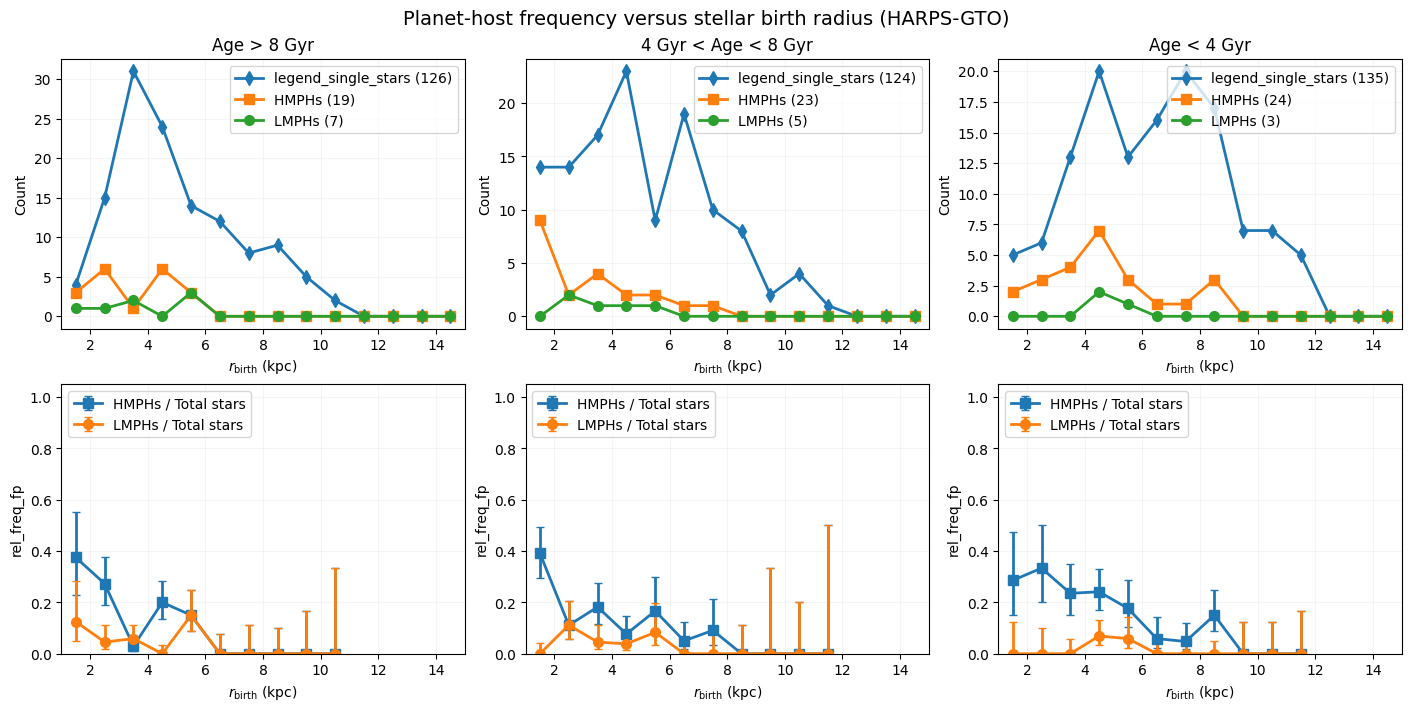

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================================================
# [ACAP_003|FIGURE_2] HARPS: frequency of planet hosts vs r_birth in age bins
#
# Input:
#   - data/processed/harps_rbirth_gce.csv
# Output:
#   - Figure_2 (saved via save_fig0 -> ACAP_003_Figure_2.png)
# =========================================================

# --- load ---
csv_path = PROC / "harps_rbirth_gce.csv"
df = dfh.copy() if "dfh" in globals() else pd.read_csv(csv_path)

need = {"rbirth_kpc", "age_gyr", "class"}
miss = need - set(df.columns)
if miss:
    raise KeyError(f"Missing columns in HARPS table: {miss}")

df = df[np.isfinite(df["rbirth_kpc"]) & np.isfinite(df["age_gyr"])].copy()

# --- bins (paper-like) ---
age_bins = [(8.0, 13.5), (4.0, 8.0), (0.1, 4.0)]
age_titles = [T("age_bin_old"), T("age_bin_mid"), T("age_bin_young")]

rbins = np.arange(1.0, 16.0, 1.0)  # edges: 1..15
rcent = 0.5 * (rbins[:-1] + rbins[1:])

def hist_counts(sub: pd.DataFrame, cls: str) -> np.ndarray:
    x = sub.loc[sub["class"] == cls, "rbirth_kpc"].dropna().to_numpy()
    return np.histogram(x, bins=rbins)[0]

# --- Wilson score interval (binomial), 68% (~1σ) ---
def wilson_interval(k, n, z=1.0):
    k = np.asarray(k, dtype=float)
    n = np.asarray(n, dtype=float)

    p = np.where(n > 0, k / n, np.nan)
    denom = 1.0 + (z**2) / n
    center = (p + (z**2) / (2 * n)) / denom
    half = (z * np.sqrt((p * (1 - p) + (z**2) / (4 * n)) / n)) / denom

    lo = center - half
    hi = center + half
    return p, lo, hi

# --- labels (i18n) ---
X_RB = L("r_birth")                 # "$r_{\\rm birth}$ (kpc)" / "..."
Y_N  = L("count")                   # "Count" / "Количество"
Y_FP = L("rel_freq_fp")             # "Relative Frequency, $F_p$" / "..."

LEG_SINGLE = L("legend_single_stars")          # already exists in ACAP_001; reuse globally
LEG_HMPH   = L("legend_hmph")                  # add
LEG_LMPH   = L("legend_lmph")                  # add
LEG_H_FRAC = L("legend_hmph_frac")             # add
LEG_L_FRAC = L("legend_lmph_frac")             # add

TITLE = T("figure_2")                           # add

fig, axes = plt.subplots(2, 3, figsize=(14, 7), constrained_layout=True)
fig.suptitle(TITLE, fontsize=14)

for j, (a0, a1) in enumerate(age_bins):
    sub = df[(df["age_gyr"] >= a0) & (df["age_gyr"] < a1)].copy()

    Ns = hist_counts(sub, "single")
    Nh = hist_counts(sub, "HMPH")
    Nl = hist_counts(sub, "LMPH")
    Nt = Ns + Nh + Nl

    # ---------- Top: counts ----------
    ax = axes[0, j]
    ax.plot(rcent, Ns, marker="d", markersize=7, linewidth=2,
            label=f"{LEG_SINGLE} ({int((sub['class']=='single').sum())})")
    ax.plot(rcent, Nh, marker="s", markersize=7, linewidth=2,
            label=f"{LEG_HMPH} ({int((sub['class']=='HMPH').sum())})")
    ax.plot(rcent, Nl, marker="o", markersize=7, linewidth=2,
            label=f"{LEG_LMPH} ({int((sub['class']=='LMPH').sum())})")

    ax.set_title(age_titles[j])
    ax.set_xlabel(X_RB)
    ax.set_ylabel(Y_N)
    ax.set_xlim(rbins[0], rbins[-1])
    ax.grid(alpha=0.2)
    ax.legend(loc="upper right", frameon=True)

    # ---------- Bottom: fractions ----------
    ax = axes[1, j]

    ph, loh, hih = wilson_interval(Nh, Nt, z=1.0)
    pl, lol, hil = wilson_interval(Nl, Nt, z=1.0)

    eh_low, eh_high = ph - loh, hih - ph
    el_low, el_high = pl - lol, hil - pl

    ax.errorbar(
        rcent, ph,
        yerr=np.vstack([eh_low, eh_high]),
        marker="s", markersize=7, linewidth=2, capsize=3,
        label=LEG_H_FRAC
    )
    ax.errorbar(
        rcent, pl,
        yerr=np.vstack([el_low, el_high]),
        marker="o", markersize=7, linewidth=2, capsize=3,
        label=LEG_L_FRAC
    )

    ax.set_xlabel(X_RB)
    ax.set_ylabel(Y_FP)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(rbins[0], rbins[-1])
    ax.grid(alpha=0.2)
    ax.legend(loc="upper left", frameon=True)

save_fig0("Figure_2", fig=fig)
plt.show()

*Figure 2. Number of stars and exoplanet frequency as a function of birth radius divided by age. (`HARPS` data)*

### Overview of Figure 2

This figure shows the dependence of planet occurrence on **Galactocentric birth radius** for stars of different ages, based on the reconstructed birth radii from the Galactic chemical evolution model.

The sample is divided into three stellar age bins:
- **Age > 8 Gyr** (left column),
- **4 Gyr < Age < 8 Gyr** (middle column),
- **Age < 4 Gyr** (right column).

For each age bin, two complementary diagnostics are presented:

**Top row — Star counts**
- The number of single stars, high-mass planet hosts (HMPHs), and low-mass planet hosts (LMPHs) as a function of birth radius.
- In all age bins, the majority of stars originate from Galactocentric radii of a few kiloparsecs, reflecting the underlying Galactic stellar population.
- Planet-hosting stars, especially HMPHs, are strongly concentrated toward smaller birth radii.

**Bottom row — Relative planet frequency**
- The fraction of HMPHs and LMPHs relative to the total stellar population in each radial bin.
- Error bars represent binomial uncertainties.
- HMPHs exhibit a systematically higher occurrence at small birth radii, particularly for younger and intermediate-age stars.
- At large birth radii, planet occurrence rapidly declines and becomes consistent with zero within uncertainties.

Across all age bins, the same qualitative behavior is observed:
- Planet formation is more efficient in the **inner Galactic disk**, where metallicity and star-formation efficiency are higher.
- The strength of the radial dependence decreases for older stars, consistent with radial migration and dynamical mixing over Galactic time.

This figure demonstrates how combining stellar ages with reconstructed birth radii reveals the **time-dependent Galactic environment of planet formation**.

While the qualitative trends agree with the literature [baba2023sunbirth], the detailed shape of the distributions differs due to the use of a simplified GCE model and an independent age reconstruction.

## Why exact reproduction is hard

In principle, using the same observational data and a published methodology should lead to similar results. In practice, however, exact reproduction of complex, data-driven figures is often difficult, even when all major ingredients appear to be available. This is not a failure of the scientific method, but rather a reflection of how modern astrophysical analyses are actually performed. Many intermediate choices — such as quality cuts, sample definitions, binning schemes, parameter limits, or the treatment of outliers — are rarely fully specified in publications, yet they can noticeably affect the detailed appearance of the final figures.

In addition, physically motivated reconstructions, such as stellar ages or Galactocentric birth radii, necessarily rely on simplified and partially degenerate models. Small differences in the assumed Galactic chemical evolution prescription, age–metallicity relation, or uncertainty handling can shift individual stars between bins and subtly reshape distributions, while leaving the underlying physical trends intact. As a result, independently reconstructed figures may differ quantitatively from published ones, even when they are fully consistent at a qualitative and interpretative level.

Crucially, the scientific conclusions of such studies do not depend on the exact height of individual histogram bins or the precise placement of error bars. Instead, they rest on robust, reproducible trends that persist under reasonable variations of the assumptions. Reproducing these qualitative behaviors — rather than achieving pixel-perfect agreement — is therefore the appropriate benchmark for validation. Exact numerical agreement typically requires access to additional, implicit methodological choices or direct communication with the original authors, which reflects standard practice in contemporary astrophysical research rather than a lack of rigor or reproducibility.

## Final Conclusions

In this notebook we constructed a complete, observation-driven workflow for linking stellar properties to their Galactic formation environments, with a particular focus on planet-hosting stars.

Starting from heterogeneous observational sources (HARPS, SWEET-Cat, and the NASA Exoplanet Archive), we built a coherent data pipeline that:
- harmonizes stellar parameters across catalogs,
- assigns planetary host classifications in a reproducible way,
- derives stellar ages using physically motivated stellar evolution models,
- and reconstructs Galactocentric birth radii using an explicit Galactic chemical evolution prescription.

A key aspect of this work is the clear separation between data sources, intermediate products, and final visualizations. All major transformation steps are saved as intermediate CSV files, ensuring that the entire analysis can be rerun, inspected, or modified without re-querying external services.

By combining stellar ages, metallicities, and reconstructed birth radii, we were able to explore how planet-hosting stars populate the Galactic disk in both space and time. The resulting figures reveal several robust trends:
- High-mass and low-mass planet hosts occupy different regions of age–radius space.
- The relative frequency of planet hosts depends on both stellar age and inferred birth radius.
- These trends are consistent with a scenario in which planet formation efficiency is shaped by the chemical evolution of the Galactic disk and modulated by stellar migration.

Importantly, the analysis highlights the limits of exact figure reproduction in complex, model-assisted studies. While our reconstructed distributions may differ in detail from published results, they reproduce the same qualitative behaviors and physical interpretations. This underscores a central lesson of Galactic archaeology: scientific insight arises from robust trends, not from pixel-perfect agreement.

Overall, this notebook demonstrates how modern Galactic studies integrate large surveys, stellar evolution models, and simplified chemical evolution prescriptions into a transparent and reproducible analysis framework. The resulting pipeline provides a solid foundation for the next stage of the practicum, where these reconstructed birth radii will be used to test specific hypotheses about planet formation, migration, and the chemical history of the Milky Way.

## References